<a href="https://colab.research.google.com/github/Arghavankas2022/NMA/blob/main/CALMS21_Autoregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules and Data

In [ ]:
## Importing necessary modules

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Download and unzip the data
import os, requests, zipfile

fname = 'task1_classic_classification.zip'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/task1_classic_classification.zip?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
else:
  print('Data have already been downloaded!!!')

if not os.path.exists('task1_classic_classification'):
  # Unzip the file
  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('.')


# Download the script
fname = 'calms21_convert_to_npy.py'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/calms21_convert_to_npy.py?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# Save the data
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.'

Saving ./calms21_task1_train
Saving ./calms21_task1_test


In [ ]:
# Defining and running the load data function
def load_task1_data(data_path):
  """
  Load data for task 1:
      The vocaubulary tells you how to map behavior names to class ids;
      it is the same for all sequences in this dataset.
  """
  data_dict = np.load(data_path, allow_pickle=True).item()
  dataset = data_dict['annotator-id_0']
  # Get any sequence key.
  sequence_id = list(data_dict['annotator-id_0'].keys())[0]
  vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
  return dataset, vocabulary

training_data, vocab = load_task1_data('./calms21_task1_train.npy')
test_data, _ = load_task1_data('./calms21_task1_test.npy')

# Data Wrangling

In [ ]:
# Filter datasets to those >8min

def filter_sequences_by_frame_count(dataset, min_frame_count):
  filtered_dataset = {k: v for k, v in dataset.items() if len(v['annotations']) > min_frame_count}
  return filtered_dataset

filter_data = filter_sequences_by_frame_count(training_data, 14400)

In [ ]:
# Reduce datasets to length 8min

for key in filter_data:
    filter_data[key]['annotations'] = filter_data[key]['annotations'][:14400]

In [ ]:
print("Vocabulary: ", vocab)

Vocabulary:  {'attack': 0, 'investigation': 1, 'mount': 2, 'other': 3}


In [ ]:
# Recode aggression to 1 and any other behaviour to 0

def recode_data(dataset, behaviour):
    recode = {}

    # Iterate through each key in the dataset
    for key in dataset:
        recode[key] = []
        # Iterate through each annotation for the current key
        for item in dataset[key]['annotations']:
            if item == behaviour:
                recode[key].append(1)
            else:
                recode[key].append(0)

    return recode

aggression = recode_data(filter_data, 0)
investigation = recode_data(filter_data, 1)
mount = recode_data(filter_data, 2)
other = recode_data(filter_data, 3)

# Graphing Likelihood

In [ ]:
# Defining and running function which extracts the mean behaviour for each frame

def mean_behaviour(dataset):

    # Determine the maximum length of lists in the dictionary

    # Initialize a list to hold sums and counts for each position
    sums = [0] * 14400
    counts = [0] * 14400

    # Iterate through each list and update sums and counts
    for lst in dataset.values():
        for i, value in enumerate(lst):
            sums[i] += value
            counts[i] += 1

    # Calculate the mean for each position
    means = [0] * 14400
    for i in range(14400):
        means[i] = sums[i] / counts[i]

    return means

aggression_mean = mean_behaviour(aggression)
investigation_mean = mean_behaviour(investigation)
mount_mean = mean_behaviour(mount)

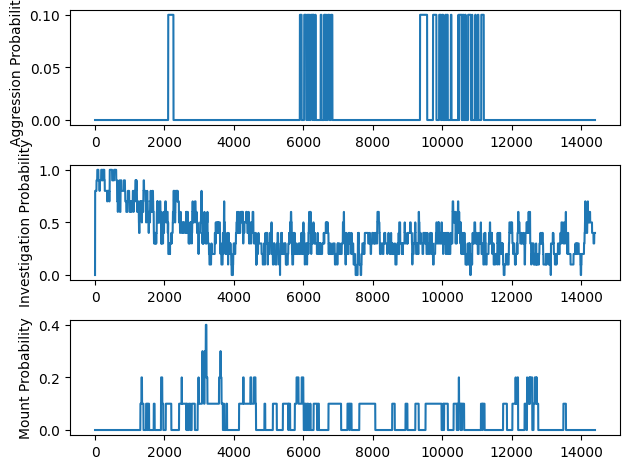

In [ ]:
# Plotting the mean of each behaviour

plt.figure()
t = range(14400)

ax1 = plt.subplot(3,1,1)
plt.plot(t, aggression_mean)
plt.ylabel('Aggression Probability')

plt.subplot(3,1,2, sharex=ax1)
plt.plot(t, investigation_mean)
plt.ylabel('Investigation Probability')

plt.subplot(3,1,3, sharex=ax1)
plt.plot(t, mount_mean)
plt.ylabel('Mount Probability')

plt.tight_layout()